# Why Use kNN for Anomaly Detection?
The k-Nearest Neighbors algorithm is particularly well-suited for anomaly detection because of its intuitive principle: normal points cluster together, while anomalies stand alone.
## Key Advantages

- Simplicity: Easy to understand and implement
- No training required: Instance-based learning stores the data
- Flexible: Works with various distance metrics
- Non-parametric: Makes no assumptions about data distribution
- Effective: Particularly good at detecting local anomalies

## How It Works
The core idea is measuring isolation. For each data point, kNN calculates:

## Distance to its k nearest neighbors
- Points with unusually large distances are flagged as anomalies
- The larger the distance, the more isolated (and suspicious) the point

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Distance-Based Anomaly Detection
The simplest approach measures the distance to the k-th nearest neighbor. Points far from their neighbors are anomalies.

In [2]:
# Generate sample data
np.random.seed(42)

# Normal data: two clusters
cluster1 = np.random.normal(loc=[2, 2], scale=0.5, size=(150, 2))
cluster2 = np.random.normal(loc=[8, 8], scale=0.5, size=(150, 2))
normal_data = np.vstack([cluster1, cluster2])

# Anomalies: scattered random points
anomalies = np.random.uniform(low=0, high=10, size=(20, 2))

# Combine all data
X = np.vstack([normal_data, anomalies])
y_true = np.array([0] * 300 + [1] * 20)  # 0 = normal, 1 = anomaly

print(f"Dataset size: {len(X)} points")
print(f"Normal points: {np.sum(y_true == 0)}")
print(f"Anomalies: {np.sum(y_true == 1)}")

Dataset size: 320 points
Normal points: 300
Anomalies: 20


scale your data

In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Detect Anomalies Using kNN Distance


In [4]:
# Set k (number of neighbors)
k = 5

# Fit the model
nbrs = NearestNeighbors(n_neighbors=k + 1)  # +1 because the point itself is included
nbrs.fit(X_scaled)

# Calculate distances
distances, indices = nbrs.kneighbors(X_scaled)

# Anomaly score = average distance to k neighbors (excluding self)
anomaly_scores = np.mean(distances[:, 1:], axis=1)

# Set threshold at 95th percentile
threshold = np.percentile(anomaly_scores, 95)
predictions = (anomaly_scores > threshold).astype(int)

print(f"\nAnomaly Detection Results:")
print(f"Threshold: {threshold:.4f}")
print(f"Detected anomalies: {np.sum(predictions == 1)}")
print(f"Actual anomalies: {np.sum(y_true == 1)}")


Anomaly Detection Results:
Threshold: 0.2809
Detected anomalies: 16
Actual anomalies: 20


Visualization: Distance-Based Detection


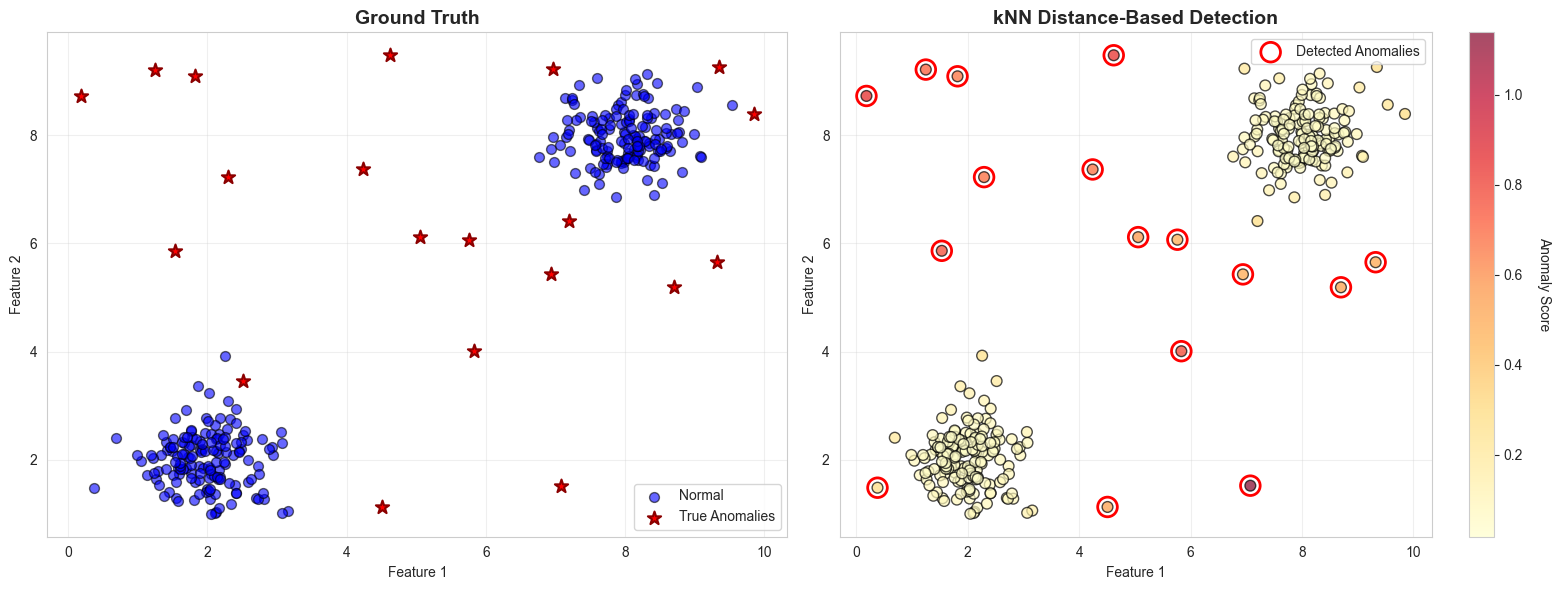

In [5]:
# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Original data with true labels
ax1 = axes[0]
ax1.scatter(X[y_true == 0, 0], X[y_true == 0, 1],
           c='blue', alpha=0.6, s=50, label='Normal', edgecolors='k')
ax1.scatter(X[y_true == 1, 0], X[y_true == 1, 1],
           c='red', s=100, marker='*', label='True Anomalies',
           edgecolors='darkred', linewidths=1.5)
ax1.set_title('Ground Truth', fontsize=14, fontweight='bold')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Detected anomalies with color-coded scores
ax2 = axes[1]
scatter = ax2.scatter(X[:, 0], X[:, 1], c=anomaly_scores,
                     cmap='YlOrRd', s=60, alpha=0.7, edgecolors='k')
ax2.scatter(X[predictions == 1, 0], X[predictions == 1, 1],
           facecolors='none', edgecolors='red', s=200,
           linewidths=2, label='Detected Anomalies')
ax2.set_title('kNN Distance-Based Detection', fontsize=14, fontweight='bold')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Anomaly Score', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

Performance Evaluation


In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("\nPerformance Metrics:")
print(f"Precision: {precision_score(y_true, predictions):.3f}")
print(f"Recall: {recall_score(y_true, predictions):.3f}")
print(f"F1-Score: {f1_score(y_true, predictions):.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, predictions))


Performance Metrics:
Precision: 0.938
Recall: 0.750
F1-Score: 0.833

Confusion Matrix:
[[299   1]
 [  5  15]]


# Method 2: Local Outlier Factor (LOF)
LOF is a more sophisticated density-based approach that compares the local density of a point with its neighbors. It's particularly effective for datasets with varying density.
Understanding LOF Scores

LOF ≈ 1: Normal point (similar density to neighbors)
LOF > 1: Lower density than neighbors (potential anomaly)
LOF >> 1: Much lower density (strong anomaly)

Implementation

In [7]:
# Create LOF detector
lof = LocalOutlierFactor(
    n_neighbors=20,           # Number of neighbors to consider
    contamination=0.1,        # Expected proportion of outliers
    novelty=False             # Set to True for new data prediction
)

# Fit and predict in one step
lof_predictions = lof.fit_predict(X_scaled)

# Convert predictions: -1 (anomaly) -> 1, 1 (normal) -> 0
lof_predictions = np.where(lof_predictions == -1, 1, 0)

# Get LOF scores (higher = more anomalous)
lof_scores = -lof.negative_outlier_factor_

print(f"\nLOF Detection Results:")
print(f"Detected anomalies: {np.sum(lof_predictions == 1)}")
print(f"Top 5 anomaly scores: {np.sort(lof_scores)[-5:][::-1]}")


LOF Detection Results:
Detected anomalies: 32
Top 5 anomaly scores: [6.57035133 5.79200413 5.57202713 5.22441384 5.17766623]


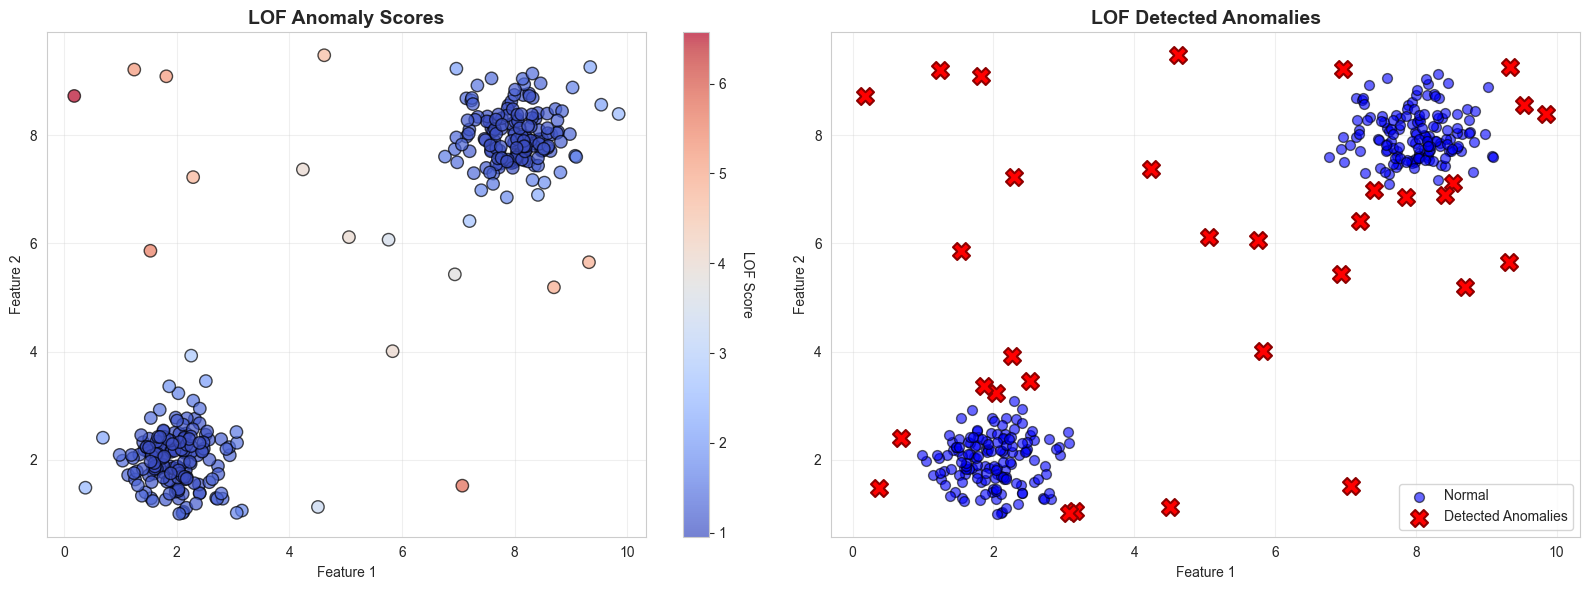


LOF Performance Metrics:
Precision: 0.625
Recall: 1.000
F1-Score: 0.769


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: LOF scores heatmap
ax1 = axes[0]
scatter = ax1.scatter(X[:, 0], X[:, 1], c=lof_scores,
                     cmap='coolwarm', s=80, alpha=0.7, edgecolors='k')
ax1.set_title('LOF Anomaly Scores', fontsize=14, fontweight='bold')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter, ax=ax1)
cbar1.set_label('LOF Score', rotation=270, labelpad=20)

# Plot 2: Detected anomalies
ax2 = axes[1]
ax2.scatter(X[lof_predictions == 0, 0], X[lof_predictions == 0, 1],
           c='blue', alpha=0.6, s=50, label='Normal', edgecolors='k')
ax2.scatter(X[lof_predictions == 1, 0], X[lof_predictions == 1, 1],
           c='red', s=150, marker='X', label='Detected Anomalies',
           edgecolors='darkred', linewidths=1.5)
ax2.set_title('LOF Detected Anomalies', fontsize=14, fontweight='bold')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance
print("\nLOF Performance Metrics:")
print(f"Precision: {precision_score(y_true, lof_predictions):.3f}")
print(f"Recall: {recall_score(y_true, lof_predictions):.3f}")
print(f"F1-Score: {f1_score(y_true, lof_predictions):.3f}")